In [55]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

In [56]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16
out_size = 10

epochs = 10
batch_size = 1000
learning_rate = 0.001

In [57]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [58]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        out = self.tanh(self.fc0(x))
        out = self.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [59]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [60]:
import pygame
from PIL import Image
import numpy as np
import time

def ensure_hw(img_t):
    if isinstance(img_t, torch.Tensor):
        t = img_t.detach().cpu().float()
        if t.ndim == 3 and t.shape[0] == 1:
            t = t[0]
        assert t.shape == (28, 28), f"got wrong shape {tuple(t.shape)}"
        t = t.clamp(0, 1)
        return t
    else:
        raise TypeError("img1 must be a Tensor")

def tensor_to_surface(t28, scale):
    arr = (t28.numpy() * 255).astype(np.uint8)
    surf = pygame.Surface((28*scale, 28*scale))
    for y in range(28):
        for x in range(28):
            v = arr[y, x]
            color = (v, v, v)
            pygame.draw.rect(surf, color, (x*scale, y*scale, scale, scale))
    return surf

def draw_grid(screen, scale, color=(40,40,40)):
    for x in range(29):
        pygame.draw.line(screen, color, (x*scale, 0), (x*scale, 28*scale))
    for y in range(29):
        pygame.draw.line(screen, color, (0, y*scale), (28*scale, y*scale))

def main(img1, scale=16, show_grid=True):
    t = ensure_hw(img1)
    t_orig = t.clone()

    pygame.init()
    pygame.display.set_caption("MNIST editor with for mouse: Left=Black, Right=White, Mid=Toggle")
    screen = pygame.display.set_mode((28*scale, 28*scale))
    clock = pygame.time.Clock()

    def redraw():
        surf = tensor_to_surface(t, scale)
        screen.blit(surf, (0,0))
        if show_grid:
            draw_grid(screen, scale)
        pygame.display.flip()

    def set_pixel_from_mouse(pos, button):
        mx, my = pos
        x = mx // scale
        y = my // scale
        if x < 0 or x >= 28 or y < 0 or y >= 28:
            return
        if button == 1:
            t[y, x] = 0.0
        elif button == 3:
            t[y, x] = 1.0
        elif button == 2:
            t[y, x] = 0.0 if t[y, x] >= 0.5 else 1.0

    running = True
    first = True
    t.copy_(t_orig)
    redraw()
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

            elif event.type == pygame.MOUSEBUTTONDOWN:
                set_pixel_from_mouse(event.pos, event.button)
                redraw()

            elif event.type == pygame.MOUSEMOTION:
                if event.buttons[0] or event.buttons[1] or event.buttons[2]:
                    btn = 1 if event.buttons[0] else (3 if event.buttons[2] else 2)
                    set_pixel_from_mouse(event.pos, btn)
                    redraw()

            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:
                    running = False
                elif event.key == pygame.K_r:
                    t.copy_(t_orig)
                    redraw()

            if first:
                time.sleep(1)
                first = False
                t.copy_(t_orig)
                redraw()

        clock.tick(120)

    pygame.quit()
    return t


772


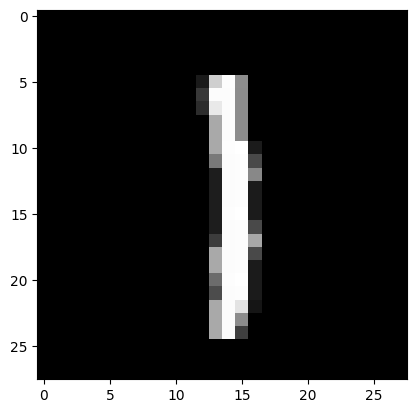

In [81]:
import random as ra
import matplotlib.pyplot as plt

inputs, labels = next(iter(test_loader))
dig_to_check = 1

while True:
    ind = 772 #ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img1 = inputs[ind].squeeze()
        break

plt.imshow(img1, cmap="gray")
print(ind)

Prediction Model: 2
tensor([[ 2.0609, -0.4400,  2.3620, -1.1954,  0.5703,  0.3310,  2.2517,  0.1964,
         -0.6796, -1.0324]], device='cuda:0', grad_fn=<AddmmBackward0>)


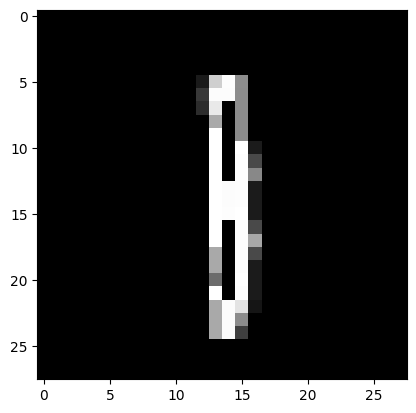

In [83]:
edited = main(img1)
plt.imshow(edited, cmap="gray")

pr = net(edited.cuda().view(-1, 28*28))
print(f"Prediction Model: {torch.argmax(pr)}\n{pr}")